> **Tip**: Welcome to the Investigate a Dataset project! You will find tips in quoted sections like this to help organize your approach to your investigation. Once you complete this project, remove these **Tip** sections from your report before submission. First things first, you might want to double-click this Markdown cell and change the title so that it reflects your dataset and investigation.

# Project: Investigate a Dataset - [Dataset-name]

## Table of Contents
<ul>
<li><a href="#intro">Introduction</a></li>
<li><a href="#wrangling">Data Wrangling</a></li>
<li><a href="#eda">Exploratory Data Analysis</a></li>
<li><a href="#conclusions">Conclusions</a></li>
</ul>

<a id='intro'></a>
## Introduction

### TMDb movie data

> **Tip**: In this section of the report, provide a brief introduction to the dataset you've selected/downloaded for analysis. Read through the description available on the homepage-links present [here](https://docs.google.com/document/d/e/2PACX-1vTlVmknRRnfy_4eTrjw5hYGaiQim5ctr9naaRd4V9du2B5bxpd8FEH3KtDgp8qVekw7Cj1GLk1IXdZi/pub?embedded=True). List all column names in each table, and their significance. In case of multiple tables, describe the relationship between tables. 


### Question(s) for Analysis
>**Tip**: Clearly state one or more questions that you plan on exploring over the course of the report. You will address these questions in the **data analysis** and **conclusion** sections. Try to build your report around the analysis of at least one dependent variable and three independent variables. If you're not sure what questions to ask, then make sure you familiarize yourself with the dataset, its variables and the dataset context for ideas of what to explore.

> **Tip**: Once you start coding, use NumPy arrays, Pandas Series, and DataFrames where appropriate rather than Python lists and dictionaries. Also, **use good coding practices**, such as, define and use functions to avoid repetitive code. Use appropriate comments within the code cells, explanation in the mark-down cells, and meaningful variable names. 

In [ ]:
# Load libraries that will be used in the work analysis
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline

In [ ]:
# Upgrade pandas to use dataframe.explode() function. 
!pip install --upgrade pandas==0.25.0

<a id='wrangling'></a>
## Data Wrangling

> **Tip**: In this section of the report, you will load in the data, check for cleanliness, and then trim and clean your dataset for analysis. Make sure that you **document your data cleaning steps in mark-down cells precisely and justify your cleaning decisions.**


### General Properties
> **Tip**: You should _not_ perform too many operations in each cell. Create cells freely to explore your data. One option that you can take with this project is to do a lot of explorations in an initial notebook. These don't have to be organized, but make sure you use enough comments to understand the purpose of each code cell. Then, after you're done with your analysis, create a duplicate notebook where you will trim the excess and organize your steps so that you have a flowing, cohesive report.

In [5]:
# Load your data and print out a few lines. Perform operations to inspect data
# Read the CSV File Using Pandas read_csv function and show the head column of the entire dataset.
import pandas as pd
df_movies= pd.read_csv("tmdb-movies.csv")
df_movies.head()
df_movies.shape

(10866, 21)

In [9]:
# show the column names and information summary about the dataset then describe the dataset. 
df_movies.columns
df_movies.info()
df_movies.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 21 columns):
id                      10866 non-null int64
imdb_id                 10856 non-null object
popularity              10866 non-null float64
budget                  10866 non-null int64
revenue                 10866 non-null int64
original_title          10866 non-null object
cast                    10790 non-null object
homepage                2936 non-null object
director                10822 non-null object
tagline                 8042 non-null object
keywords                9373 non-null object
overview                10862 non-null object
runtime                 10866 non-null int64
genres                  10843 non-null object
production_companies    9836 non-null object
release_date            10866 non-null object
vote_count              10866 non-null int64
vote_average            10866 non-null float64
release_year            10866 non-null int64
budget_adj              1

,id,popularity,budget,revenue,runtime,vote_count,vote_average,release_year,budget_adj,revenue_adj
count,10866.000000,10866.000000,1.086600e+04,1.086600e+04,10866.000000,10866.000000,10866.000000,10866.000000,1.086600e+04,1.086600e+04
mean,66064.177434,0.646441,1.462570e+07,3.982332e+07,102.070863,217.389748,5.974922,2001.322658,1.755104e+07,5.136436e+07
std,92130.136561,1.000185,3.091321e+07,1.170035e+08,31.381405,575.619058,0.935142,12.812941,3.430616e+07,1.446325e+08
min,5.000000,0.000065,0.000000e+00,0.000000e+00,0.000000,10.000000,1.500000,1960.000000,0.000000e+00,0.000000e+00
25%,10596.250000,0.207583,0.000000e+00,0.000000e+00,90.000000,17.000000,5.400000,1995.000000,0.000000e+00,0.000000e+00
50%,20669.000000,0.383856,0.000000e+00,0.000000e+00,99.000000,38.000000,6.000000,2006.000000,0.000000e+00,0.000000e+00
75%,75610.000000,0.713817,1.500000e+07,2.400000e+07,111.000000,145.750000,6.600000,2011.000000,2.085325e+07,3.369710e+07
max,417859.000000,32.985763,4.250000e+08,2.781506e+09,900.000000,9767.000000,9.200000,2015.000000,4.250000e+08,2.827124e+09



### Data Cleaning
> **Tip**: Make sure that you keep your reader informed on the steps that you are taking in your investigation. Follow every code cell, or every set of related code cells, with a markdown cell to describe to the reader what was found in the preceding cell(s). Try to make it so that the reader can then understand what they will be seeing in the following cell(s).
 

In [37]:
# in this part we are going to clean all unused information from the data set
# drop all the  Duplicated Rows
df_movies.duplicated().sum()
df_movies.drop_duplicates(inplace=True)
print("Afetr Removing Duplicate Values (Rows,Columns) : ",df_movies.shape)

Afetr Removing Duplicate Values (Rows,Columns) :  (10865, 22)


In [16]:
# Changing Format Of Release Date Into Datetime Format
df_movies['release_date'] = pd.to_datetime(df_movies['release_date'])
df_movies['release_date'].head()

0   2015-06-09
1   2015-05-13
2   2015-03-18
3   2015-12-15
4   2015-04-01
Name: release_date, dtype: datetime64[ns]

In [65]:
# drop all the Unecessary Columns that have null values
df_movies.isna().sum()
s=df_movies.dropna(axis=1)
s.info()
s.head()
# calcultae the shape of the new dataset.shape
print("Afetr Removing all the Unecessary data the shape of the new data set is: ",s.shape)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10866 entries, 0 to 10865
Data columns (total 12 columns):
id                10866 non-null int64
popularity        10866 non-null float64
budget            10866 non-null int64
revenue           10866 non-null int64
original_title    10866 non-null object
runtime           10866 non-null int64
release_date      10866 non-null object
vote_count        10866 non-null int64
vote_average      10866 non-null float64
release_year      10866 non-null int64
budget_adj        10866 non-null float64
revenue_adj       10866 non-null float64
dtypes: float64(4), int64(6), object(2)
memory usage: 1018.8+ KB
Afetr Removing all the Unecessary data the shape of the new data set is:  (10866, 12)




<a id='eda'></a>
## Exploratory Data Analysis

> **Tip**: Now that you've trimmed and cleaned your data, you're ready to move on to exploration. **Compute statistics** and **create visualizations** with the goal of addressing the research questions that you posed in the Introduction section. You should compute the relevant statistics throughout the analysis when an inference is made about the data. Note that at least two or more kinds of plots should be created as part of the exploration, and you must  compare and show trends in the varied visualizations. 



> **Tip**: - Investigate the stated question(s) from multiple angles. It is recommended that you be systematic with your approach. Look at one variable at a time, and then follow it up by looking at relationships between variables. You should explore at least three variables in relation to the primary question. This can be an exploratory relationship between three variables of interest, or looking at how two independent variables relate to a single dependent variable of interest. Lastly, you  should perform both single-variable (1d) and multiple-variable (2d) explorations.


### Research Question 1 (What month is considered "best" for releas in film/show?)

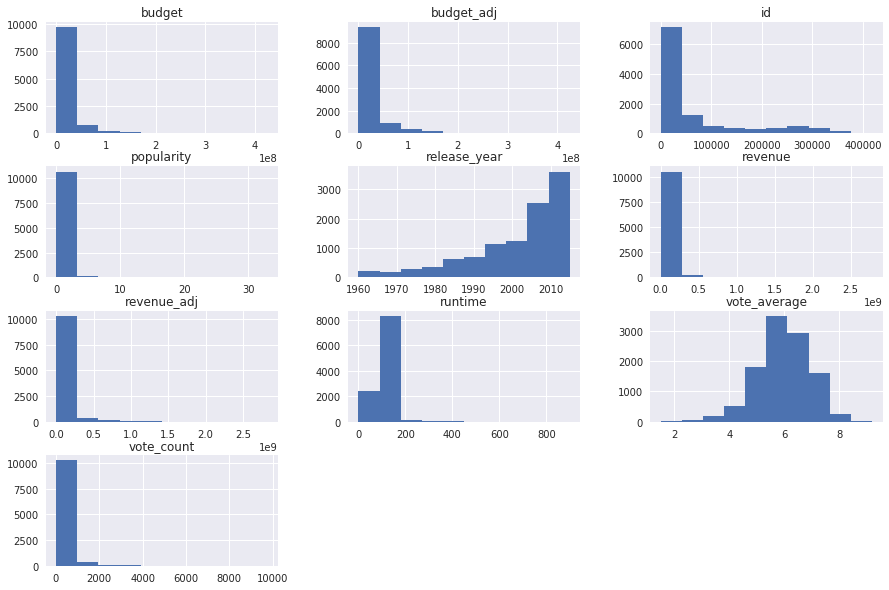

In [72]:
# Explore what the histogram of the dataset looks like
s.hist(figsize=(15,10));

In [23]:
# "Best" is a label that defines movies that have the top revenues. So i'll explore month(s) have the highest revenues.
# First, i'll create a new column called "month".
# Then i'll extract the month from release_date.
df_movies['month'] = df_movies['release_date'].apply(lambda x: x.month)
df_movies['month'].head(13)

0      6
1      5
2      3
3     12
4      4
5     12
6      6
7      9
8      6
9      6
10    10
11     2
12     1
Name: month, dtype: int64

In [24]:
# Group by month and sum the revenues.
month_revenue = df_movies.groupby('month')['revenue_adj'].sum()
month_revenue

month
1     1.741505e+10
2     2.345234e+10
3     4.069289e+10
4     3.165386e+10
5     6.168336e+10
6     8.071322e+10
7     5.856037e+10
8     3.255990e+10
9     3.095786e+10
10    3.844519e+10
11    5.849808e+10
12    8.349306e+10
Name: revenue_adj, dtype: float64

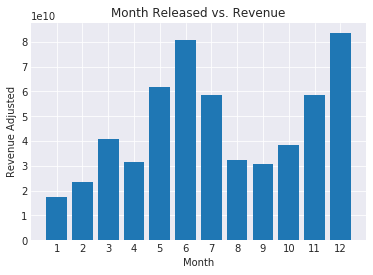

In [35]:
# Now plot these in a bar chart.
import matplotlib.pyplot as plt
import seaborn as sns
% matplotlib inline
plt.bar([1,2,3,4,5,6,7,8,9,10,11,12], month_revenue, tick_label = [1,2,3,4,5,6,7,8,9,10,11,12])
plt.title('Month Released vs. Revenue')
plt.ylabel('Revenue Adjusted')
plt.xlabel('Month');

In [ ]:
#From this chart, we can see that the month of June and month of December have the highest revenue formovie releases.  
#However, to make this conclusive, I must check the number of movie releases each month, because there could be a few high-earning movies that skew the data.

In [32]:
df_movies['month'].value_counts()

9     1331
10    1153
12     985
1      919
8      918
6      827
3      823
11     814
5      809
7      799
4      797
2      691
Name: month, dtype: int64

In [34]:
df_movies['month'].value_counts().mean()

905.5

In [ ]:
# Although the number of movie releases ranges from 691-1331, June and December are not far from the average number of 905.5 releases/month.
#This means there's no significant data to conclude there were a few high-earning movies that skewed the data, or that there were more movie releases during those months.
# Therefore, we can still conclude June and December are "better" months to release movies in, as they'll most likely produce the highest revenue

### Research Question 2  (What is the relationship between runtime and vote average?)

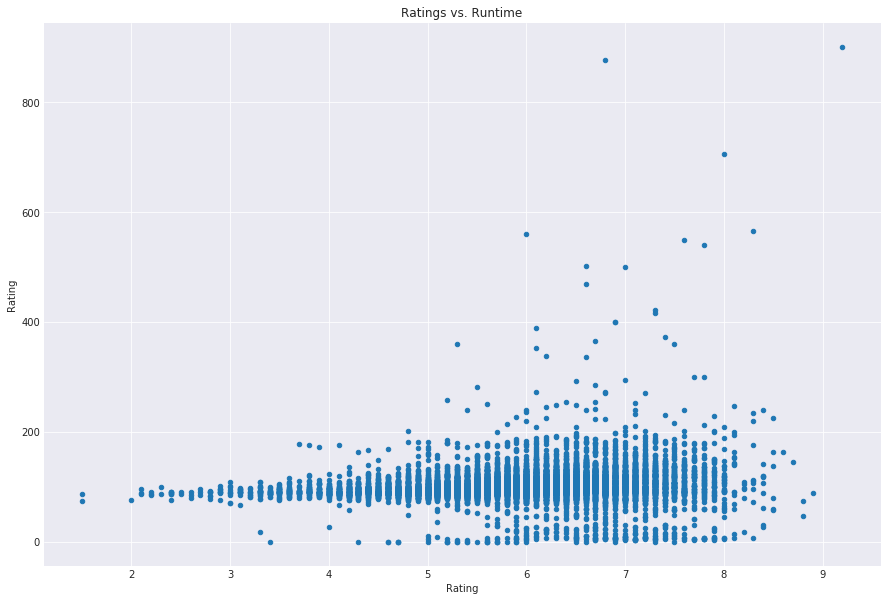

In [36]:
# Plot scatter plot of these two columns
df_movies.plot(x='vote_average', y='runtime', kind='scatter', figsize=(15,10))
plt.title('Ratings vs. Runtime')
plt.xlabel('Rating')
plt.ylabel('Rating');

In [ ]:
#it's a short film, it's likely to have a mid-to-high rating.#it's a short film, it's likely to have a mid-to-high rating.
#Films/shows with a runtime above or below 100 minues tend to have mid-to-high ratings.
#Tv series (or movies with long runtimes) consistently get higher-than-average ratings. 

<a id='conclusions'></a>
## Conclusions
there are around 9 columns of data is having null values and only one duplicate rows were removed  to  from the data set but they didnt affect the project 

## Submitting your Project 

> **Tip**: Before you submit your project, you need to create a .html or .pdf version of this notebook in the workspace here. To do that, run the code cell below. If it worked correctly, you should get a return code of 0, and you should see the generated .html file in the workspace directory (click on the orange Jupyter icon in the upper left).

> **Tip**: Alternatively, you can download this report as .html via the **File** > **Download as** submenu, and then manually upload it into the workspace directory by clicking on the orange Jupyter icon in the upper left, then using the Upload button.

> **Tip**: Once you've done this, you can submit your project by clicking on the "Submit Project" button in the lower right here. This will create and submit a zip file with this .ipynb doc and the .html or .pdf version you created. Congratulations!

In [47]:
from subprocess import call
call(['python', '-m', 'nbconvert', 'Investigate_a_Dataset.ipynb'])

0